# Fornax 3D Models

Some I/O and plotting using the Fornax 3D models from Vartanyan, Burrows, et al. (2019), which express the angular dependence of the neutrino luminosity from CCSNe in terms of a spherical harmonic expansion up to order $\ell=2$.

The data are available on [the Burrows group website](https://www.astro.princeton.edu/~burrows/nu-emissions.3d/).

In [1]:
%matplotlib inline

import numpy as np

from astropy.table import Table
from astropy.io import ascii, fits
import astropy.units as u

from scipy.special import gamma, lpmv

import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import healpy as hp

import os

from snewpy.neutrino import Flavor

In [2]:
mpl.rc('font', size=14)

## Calculations on the Unit Sphere

### HEALPix Functions

We'll use HEALPix to handle the angular dependence of the emission. The plots below demonstrate various angular resolutions we can choose, dependent on the $N_\mathrm{side}$ parameter of the HEALPix map.

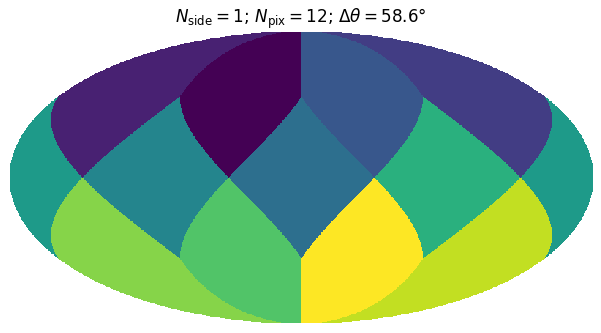

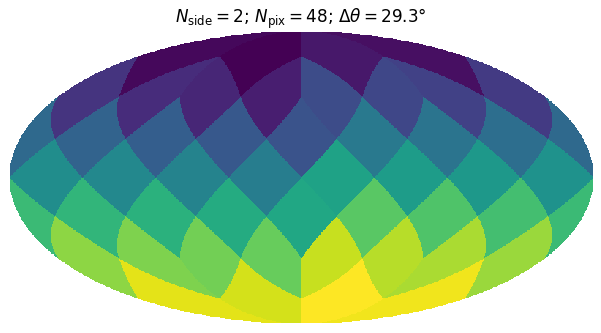

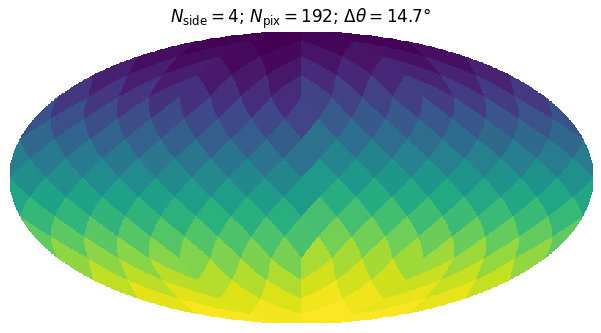

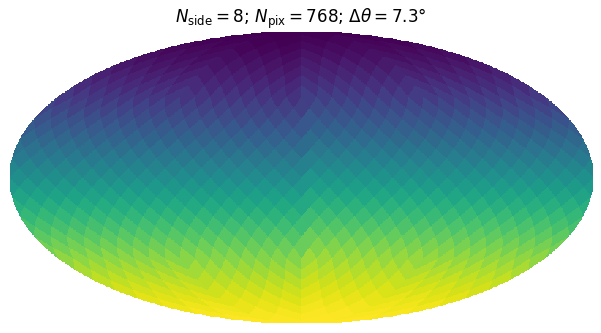

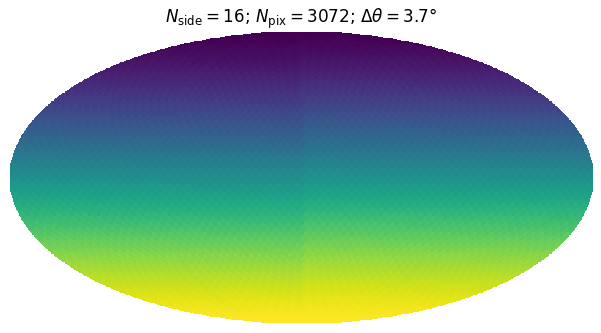

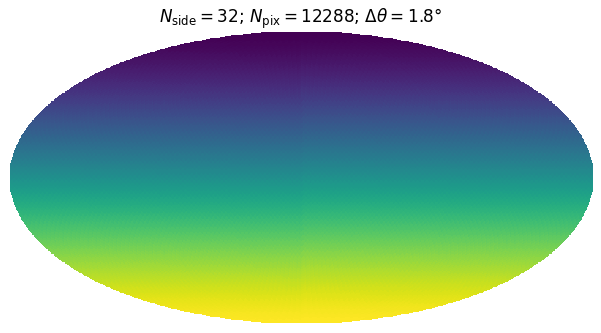

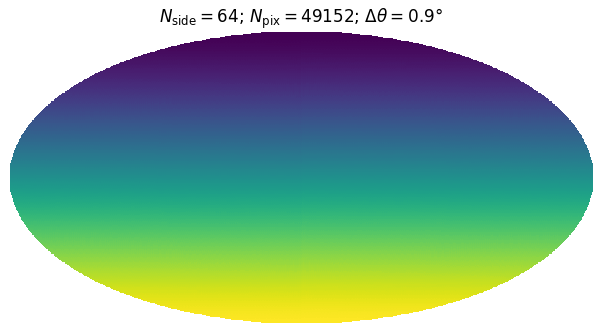

In [3]:
for k in range(7):
    nside = 2**k
    npix = hp.nside2npix(nside)
    dtheta = np.degrees(hp.nside2resol(nside))
    hp.mollview(np.arange(npix), cbar=False,
                title=r'$N_\mathrm{{side}} = {}$; $N_\mathrm{{pix}} = {}$; $\Delta\theta={:.1f}\degree$'.format(nside, npix, dtheta))

### Real-Valued Spherical (Tesseral) Harmonics

The angular dependence of the Fornax 3D models are parameterized in terms of a spherical harmonic expansion on the unit sphere carried out to order $\ell=2$. Here we use the real-valued spherical harmonics:

$$
Y_{\ell m}(\theta,\varphi) = 
\begin{cases}
  \displaystyle (-1)^m\sqrt{2} \sqrt{{2\ell+1 \over 4\pi}{(\ell-|m|)!\over (\ell+|m|)!}}
  P_\ell^{|m|}(\cos \theta) \ \sin( |m|\varphi )
  &\mbox{if } m<0
  \\
  \displaystyle \sqrt{{ 2\ell+1 \over 4\pi}} \ P_\ell^m(\cos \theta)
  &\mbox{if } m=0
  \\
  \displaystyle (-1)^m\sqrt{2} \sqrt{{2\ell+1 \over 4\pi}{(\ell-m)!\over (\ell+m)!}}
  P_\ell^m(\cos \theta) \ \cos( m\varphi )
  &\mbox{if } m>0
\end{cases}
$$

In [4]:
def fact(n):
    """
    Note: math.factorial returns an int, but we want to work only with floats
    """
    return gamma(n + 1.)

def real_sph_harm(l, m, theta, phi):
    """
    Computes the orthonormalized real spherical harmonics Y_lm
    """
    if m < 0:
        norm = np.sqrt((2*l + 1.)/(2*np.pi)*fact(l + m)/fact(l - m))
        return norm * lpmv(-m, l, np.cos(theta)) * np.sin(-m*phi)
    elif m == 0:
        norm = np.sqrt((2*l + 1.)/(4*np.pi))
        return norm * lpmv(0, l, np.cos(theta)) * np.ones_like(phi)
    else:
        norm = np.sqrt((2*l + 1.)/(2*np.pi)*fact(l - m)/fact(l + m))
        return norm * lpmv(m, l, np.cos(theta)) * np.cos(m*phi)

### Cache the $Y_{\ell m}$ Values for a Fixed $\theta,\varphi$ Grid

Use a HEALPix grid with $N_\mathrm{side}=4$ (192 pixels) to store the values of $Y_{\ell m}(\theta,\varphi)$.

In [5]:
nside = 4
npix = hp.nside2npix(nside)
pixels = np.arange(npix)
thetac, phic = hp.pix2ang(nside, pixels)

Ylm = {}
for l in range(3):
    Ylm[l] = {}
    for m in range(-l, l + 1):
        Ylm[l][m] = real_sph_harm(l, m, thetac, phic)

## Read in the $10M_\odot$ Model

In [6]:
lum_file = '../../models/Fornax_2019/lum_spec_10M.h5'
data = h5py.File(lum_file, 'r')

### Store a 3D Table of $\Delta L_\nu/\Delta E$

Extract the $\nu_e$ flux for this model and store it in a 3D array, where the array indices correspond to time, energy, and position on the sphere (indexed by HEALPixel).

Note that caching the entire simulated flux for one neutrino flavor takes about 30 s. This is bound by the I/O required to extract all the required energy coefficients vs. time from the HDF5 file.

In [7]:
time = data['nu0']['g0'].attrs['time']
E  = data['nu0']['egroup'][()]
dE = data['nu0']['degroup'][()]

ntim, nene = E.shape
npix = len(pixels)

dLdE = np.zeros((ntim, nene, npix), dtype=float)

# Loop over time bins.
for i in range(ntim):
    # Loop over energy bins.
    for j in range(nene):
        dLdE_ij = 0.
        # Sum over multipole moments.
        for l in range(3):
            for m in range(-l, l + 1):
                dLdE_ij += data['nu0']['g{}'.format(j)]['l={} m={}'.format(l,m)][i] * Ylm[l][m]
        dLdE[i][j] = dLdE_ij

### Integrate over Energy to get $L_{\nu_e}(t)$

In [8]:
L = np.sum(dLdE * dE[:,:,np.newaxis], axis=1)

### Plot $L_\nu(t,\theta,\varphi)$ at a Particular Time

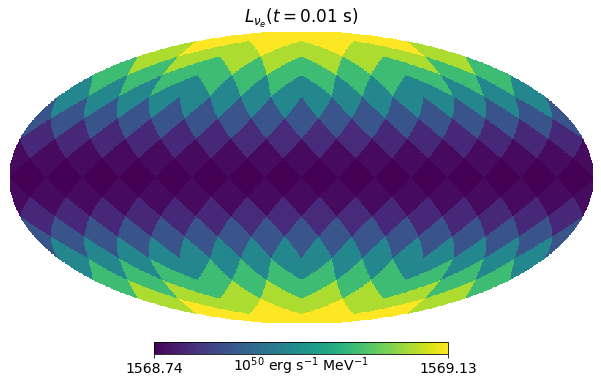

In [9]:
j = 0
hp.mollview(L[j], title=r'$L_{{\nu_e}}(t={:g}~\mathrm{{s}})$'.format(time[j]),
            unit=r'$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')

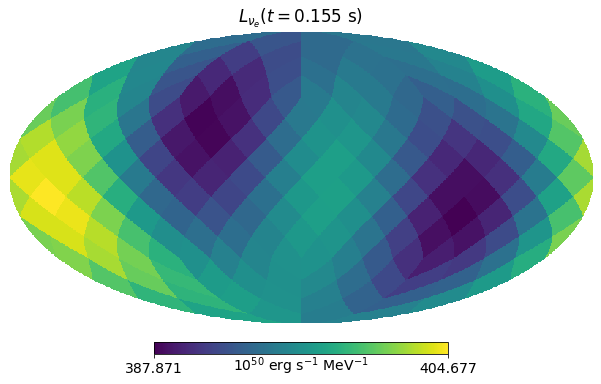

In [10]:
j = 150
hp.mollview(L[j], title=r'$L_{{\nu_e}}(t={:g}~\mathrm{{s}})$'.format(time[j]),
            unit=r'$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')

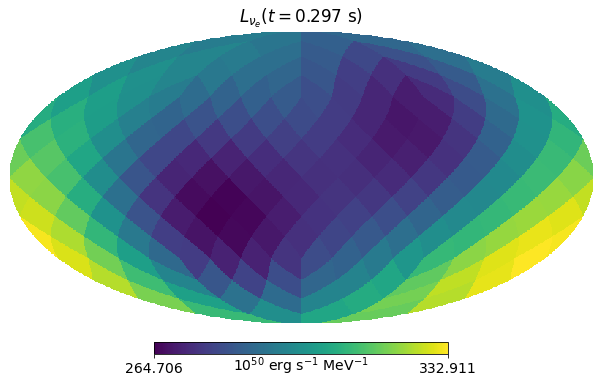

In [11]:
j = 300
hp.mollview(L[j], title=r'$L_{{\nu_e}}(t={:g}~\mathrm{{s}})$'.format(time[j]),
            unit=r'$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')

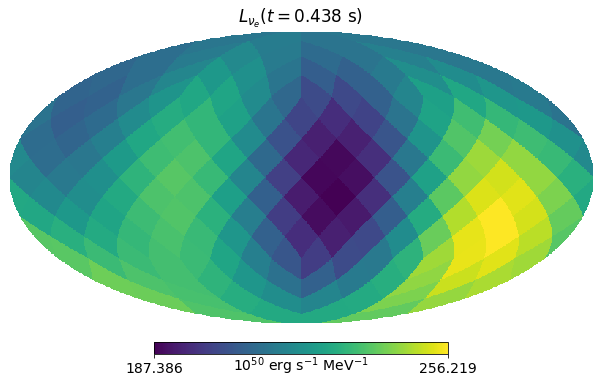

In [12]:
j = 450
hp.mollview(L[j], title=r'$L_{{\nu_e}}(t={:g}~\mathrm{{s}})$'.format(time[j]),
            unit=r'$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')

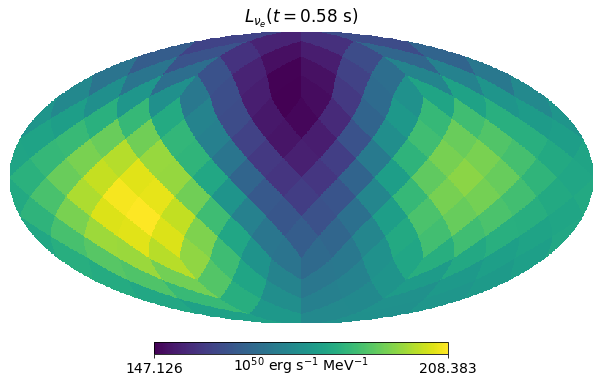

In [13]:
j = 600
hp.mollview(L[j], title=r'$L_{{\nu_e}}(t={:g}~\mathrm{{s}})$'.format(time[j]),
            unit=r'$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')

### Plot $L_\nu(t,\theta,\varphi)$ at a Particular Location

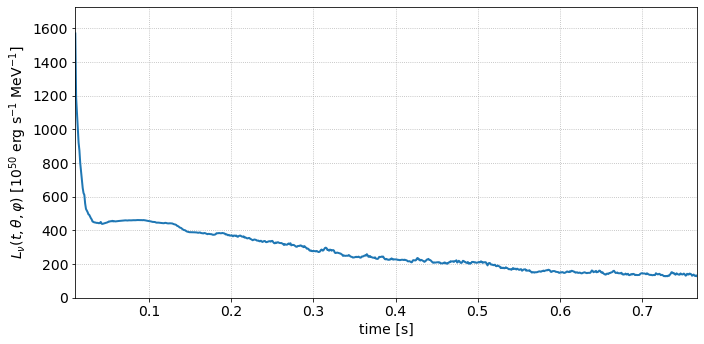

In [14]:
theta, phi = np.radians([55, 47])
k = hp.ang2pix(nside, theta, phi)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.plot(time, L[:,k], lw=2)
ax.set(xlabel='time [s]',
       xlim=(time[0], time[-1]),
       ylabel=r'$L_{\nu}(t,\theta,\varphi)$ [$10^{50}$ erg s$^{-1}$ MeV$^{-1}$]',
       ylim=(0, 1.1*np.max(L)))
ax.grid(ls=':');

### Superimpose $L_\nu(t,\theta,\varphi)$ at All Locations on the Sphere

Plot $L(t)$ at all locations as well as the average, and then the deviation from the average.

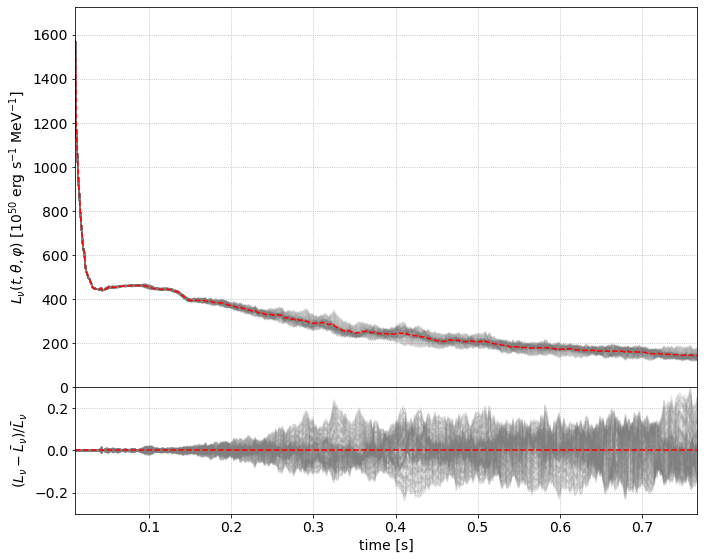

In [15]:
Lavg = np.average(L, axis=1)
dL_over_L = (L - Lavg[:,np.newaxis]) / Lavg[:,np.newaxis]

fig, axes = plt.subplots(2,1, figsize=(10,8),
                         gridspec_kw = {'height_ratios':[3,1], 'hspace':0},
                         sharex=True, tight_layout=True)

ax = axes[0]
ax.plot(time, L, color='gray', alpha=0.05)
ax.plot(time, Lavg, color='r', ls='--')
ax.set(xlim=(time[0], time[-1]),
       ylabel=r'$L_{\nu}(t,\theta,\varphi)$ [$10^{50}$ erg s$^{-1}$ MeV$^{-1}$]',
       ylim=(0, 1.1*np.max(L)))
ax.grid(ls=':')

ax = axes[1]
ax.plot(time, dL_over_L, color='gray', alpha=0.1)
ax.plot(time, np.zeros(time.shape), ls='--', color='r')
ax.set(xlabel='time [s]',
       ylabel=r'$(L_\nu - \bar{L}_\nu)/\bar{L}_\nu$',
       ylim=(-0.3, 0.3))
ax.grid(ls=':');

# Write Output to FITS

Test output to a FITS file with the `nu0` data ($\nu_e$) also standing in for the `nu1` and `nu2` data. The FITS output should be around 20x the size of the corresponding HDF5 file if we're using `Nside=4` because instead of storing $9\times12\times800$ values ($\mathrm{multipole~moments}\times\mathrm{energies}\times\mathrm{times}$) using the multipole expansion of the neutrino flux, we're storing $192\times12\times800$ ($\mathrm{directions}\times\mathrm{energies}\times\mathrm{times}$) values.

In [16]:
hx = fits.HDUList()

# Write the times to a table.
hdu_time = fits.PrimaryHDU(time)
hdu_time.header['EXTNAME'] = 'TIME'
hdu_time.header['BUNIT'] = 'second'
hx.append(hdu_time)

# For each flavor, store the energy bin, bin width, and dL/dE tables.
flavorkeys = { Flavor.NU_E:'nu0',
               Flavor.NU_E_BAR:'nu1',
               Flavor.NU_X:'nu2'}

for flavor, key in flavorkeys.items():
    print(flavor, key)
    name = str(flavor).split('.')[-1]
    
    hdu_E = fits.ImageHDU(E)
    hdu_E.header['EXTNAME'] = '{}_ENERGY'.format(name)
    hdu_E.header['BUNIT'] = 'MeV'
    hx.append(hdu_E)
    
    hdu_dE = fits.ImageHDU(dE)
    hdu_dE.header['EXTNAME'] = '{}_DE'.format(name)
    hdu_dE.header['BUNIT'] = 'MeV'
    hx.append(hdu_dE)
    
    fluxunits = 1e50 * u.erg/u.s/u.MeV
    hdu_flux = fits.ImageHDU(dLdE)
    hdu_flux.header['EXTNAME'] = '{}_FLUX'.format(name)
    hdu_flux.header['BUNIT'] = str(fluxunits)
    hx.append(hdu_flux)

# Write to FITS format.
hx.writeto('testfornax.fits', overwrite=True)

Flavor.NU_E nu0
Flavor.NU_E_BAR nu1
Flavor.NU_X nu2


#### Size of FITS Output in MB

In [17]:
os.stat('testfornax.fits').st_size / (1024**2)

42.66815185546875

#### Size of HDF5 File in MB

In [18]:
os.stat(lum_file).st_size / (1024**2)

1.9939956665039062